In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.7 MB/s eta 0:00:00


In [2]:
import os
import mne
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class ImaginedSpeechEEGDataset(Dataset):
    def __init__(self, base_dir, transform=None, subfolders=None):

        if subfolders is None:
            subfolders = ["Char", "Digit", "Image"]
        self.transform = transform


        self.files = []
        for sub in subfolders:
            folder_path = os.path.join(base_dir, sub)
            edf_files = [
                os.path.join(folder_path, f)
                for f in os.listdir(folder_path)
                if f.lower().endswith(".edf")
            ]
            self.files.extend(edf_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        edf_path = self.files[idx]

        # Load the EDF file with MNE
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        data = raw.get_data()  # shape: (channels, time)

        # Optional: you might want to select certain channels, or drop EOG/ECG if present.
        # data = data[:6, :]  # for example, if you only want the first 6 channels

        # Normalize data (optional, but recommended)
        data_mean = np.mean(data, axis=1, keepdims=True)
        data_std = np.std(data, axis=1, keepdims=True)
        data = (data - data_mean) / (data_std + 1e-6)

        # Apply any additional transform
        if self.transform:
            data = self.transform(data)

        # Convert to PyTorch tensor
        eeg_tensor = torch.tensor(data, dtype=torch.float32)

        # Return the EEG tensor only (no labels, since it's self-supervised)
        return eeg_tensor


In [4]:
base_dir = "/content/archive (2).zip"
dataset = ImaginedSpeechEEGDataset(base_dir=base_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


NotADirectoryError: [Errno 20] Not a directory: '/content/archive (2).zip/Char'

In [5]:
!unzip "/content/archive (2).zip" -d "/content/my_eeg_data"


Archive:  /content/archive (2).zip
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_A.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_C.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_F.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_H.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_J.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_M.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_P.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_S.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_T.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name0_Y.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name10_A.edf  
  inflating: /content/my_eeg_data/Imagined_speech_EEG_edf/Char/name10_C.edf  
  inflating: /content/my_eeg_data/Imagi

In [19]:
def pad_collate_fn(batch):

    max_length = max(sample.shape[1] for sample in batch)
    padded_batch = []
    for sample in batch:
        channels, time_length = sample.shape
        if time_length < max_length:

            pad_amount = max_length - time_length
            pad_tensor = torch.zeros((channels, pad_amount), dtype=sample.dtype)
            sample = torch.cat([sample, pad_tensor], dim=1)
        padded_batch.append(sample)

    return torch.stack(padded_batch)


In [20]:
base_dir = "/content/my_eeg_data/Imagined_speech_EEG_edf"

dataset = ImaginedSpeechEEGDataset(base_dir=base_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True,collate_fn=pad_collate_fn)


In [7]:
print(dataloader)

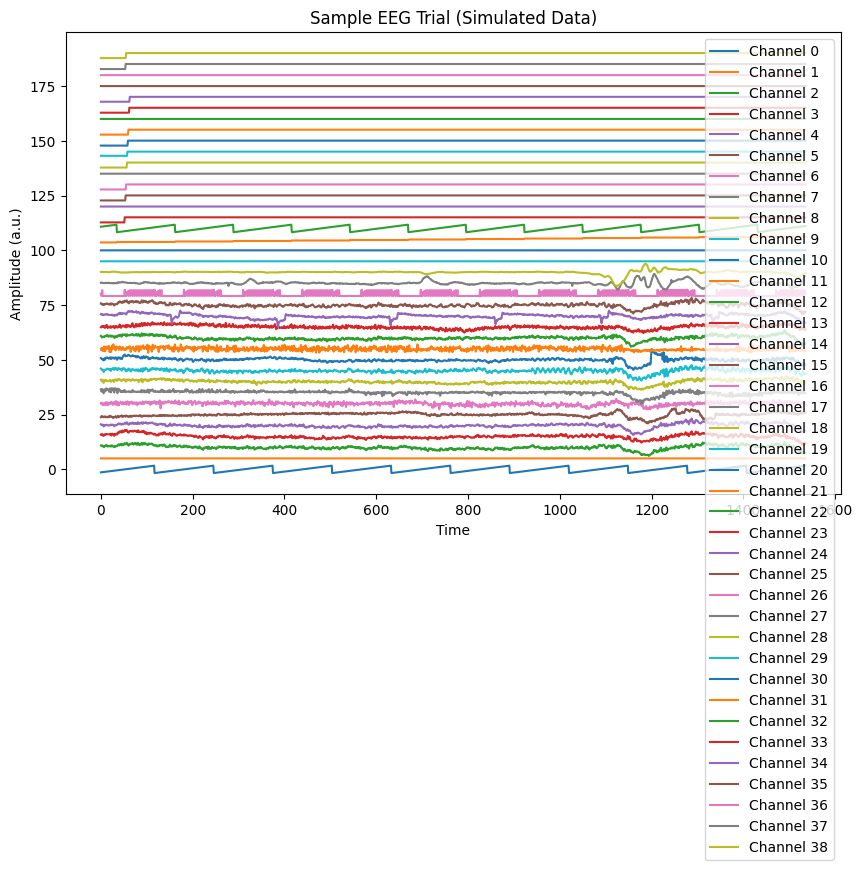

In [10]:
import matplotlib.pyplot as plt
sample_eeg = dataset[0].numpy()  # shape: (channels, time)
plt.figure(figsize=(10, 6))
for i in range(sample_eeg.shape[0]):
    plt.plot(sample_eeg[i] + i*5, label=f'Channel {i}')  # offset for clarity
plt.title("Sample EEG Trial (Simulated Data)")
plt.xlabel("Time")
plt.ylabel("Amplitude (a.u.)")
plt.legend(loc="upper right")
plt.show()

In [12]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [29]:
class MAEEG(nn.Module):
    def __init__(self, in_channels=6, token_dim=64, transformer_dim=192, num_transformer_layers=8, masking_ratio=0.25):
        super(MAEEG, self).__init__()
        self.masking_ratio = masking_ratio


        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, token_dim, kernel_size=7, stride=2, padding=3),
            nn.GELU(),
            nn.Conv1d(token_dim, token_dim, kernel_size=5, stride=2, padding=2),
            nn.GELU(),
        )

        self.proj = nn.Linear(token_dim, transformer_dim)


        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)


        self.decoder_proj = nn.Linear(transformer_dim, token_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(token_dim, token_dim, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.GELU(),
            nn.ConvTranspose1d(token_dim, in_channels, kernel_size=7, stride=2, padding=3, output_padding=1),
        )

    def random_masking(self, tokens):

        B, seq_len, _ = tokens.shape
        num_mask = int(self.masking_ratio * seq_len)
        mask = torch.zeros(B, seq_len, dtype=torch.bool, device=tokens.device)
        for i in range(B):
            perm = torch.randperm(seq_len)
            mask[i, perm[:num_mask]] = True
        return mask

    def forward(self, x):

        encoded = self.encoder(x)
        tokens = encoded.transpose(1, 2)


        tokens_proj = self.proj(tokens)

        # Apply random masking (set masked tokens to zero)
        mask = self.random_masking(tokens_proj)
        tokens_proj_masked = tokens_proj.clone()
        tokens_proj_masked[mask] = 0.0

        # Transformer encoder
        transformer_out = self.transformer(tokens_proj_masked)  # -> (B, token_seq_len, transformer_dim)

        # Project back to token dimension
        decoded_tokens = self.decoder_proj(transformer_out)  # -> (B, token_seq_len, token_dim)
        decoded_tokens = decoded_tokens.transpose(1, 2)  # -> (B, token_dim, token_seq_len)

        # Decoder: reconstruct original EEG signal
        x_recon = self.decoder(decoded_tokens)  # -> (B, in_channels, time)
        return x_recon

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Adjust in_channels based on your EDF file; here we assume 6 channels.
model = MAEEG(in_channels=39).to(device)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [31]:
num_epochs = 10  # For demonstration; increase epochs as needed

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in dataloader:
        # Each batch: (B, channels, time)
        batch = batch.to(device)
        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch.size(0)
    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.4291
Epoch 2/10, Loss: 0.4296
Epoch 3/10, Loss: 0.4326
Epoch 4/10, Loss: 0.4296
Epoch 5/10, Loss: 0.4284
Epoch 6/10, Loss: 0.4307
Epoch 7/10, Loss: 0.4295
Epoch 8/10, Loss: 0.4307
Epoch 9/10, Loss: 0.4297
Epoch 10/10, Loss: 0.4296


<ipython-input-32-553480c10477>:21: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


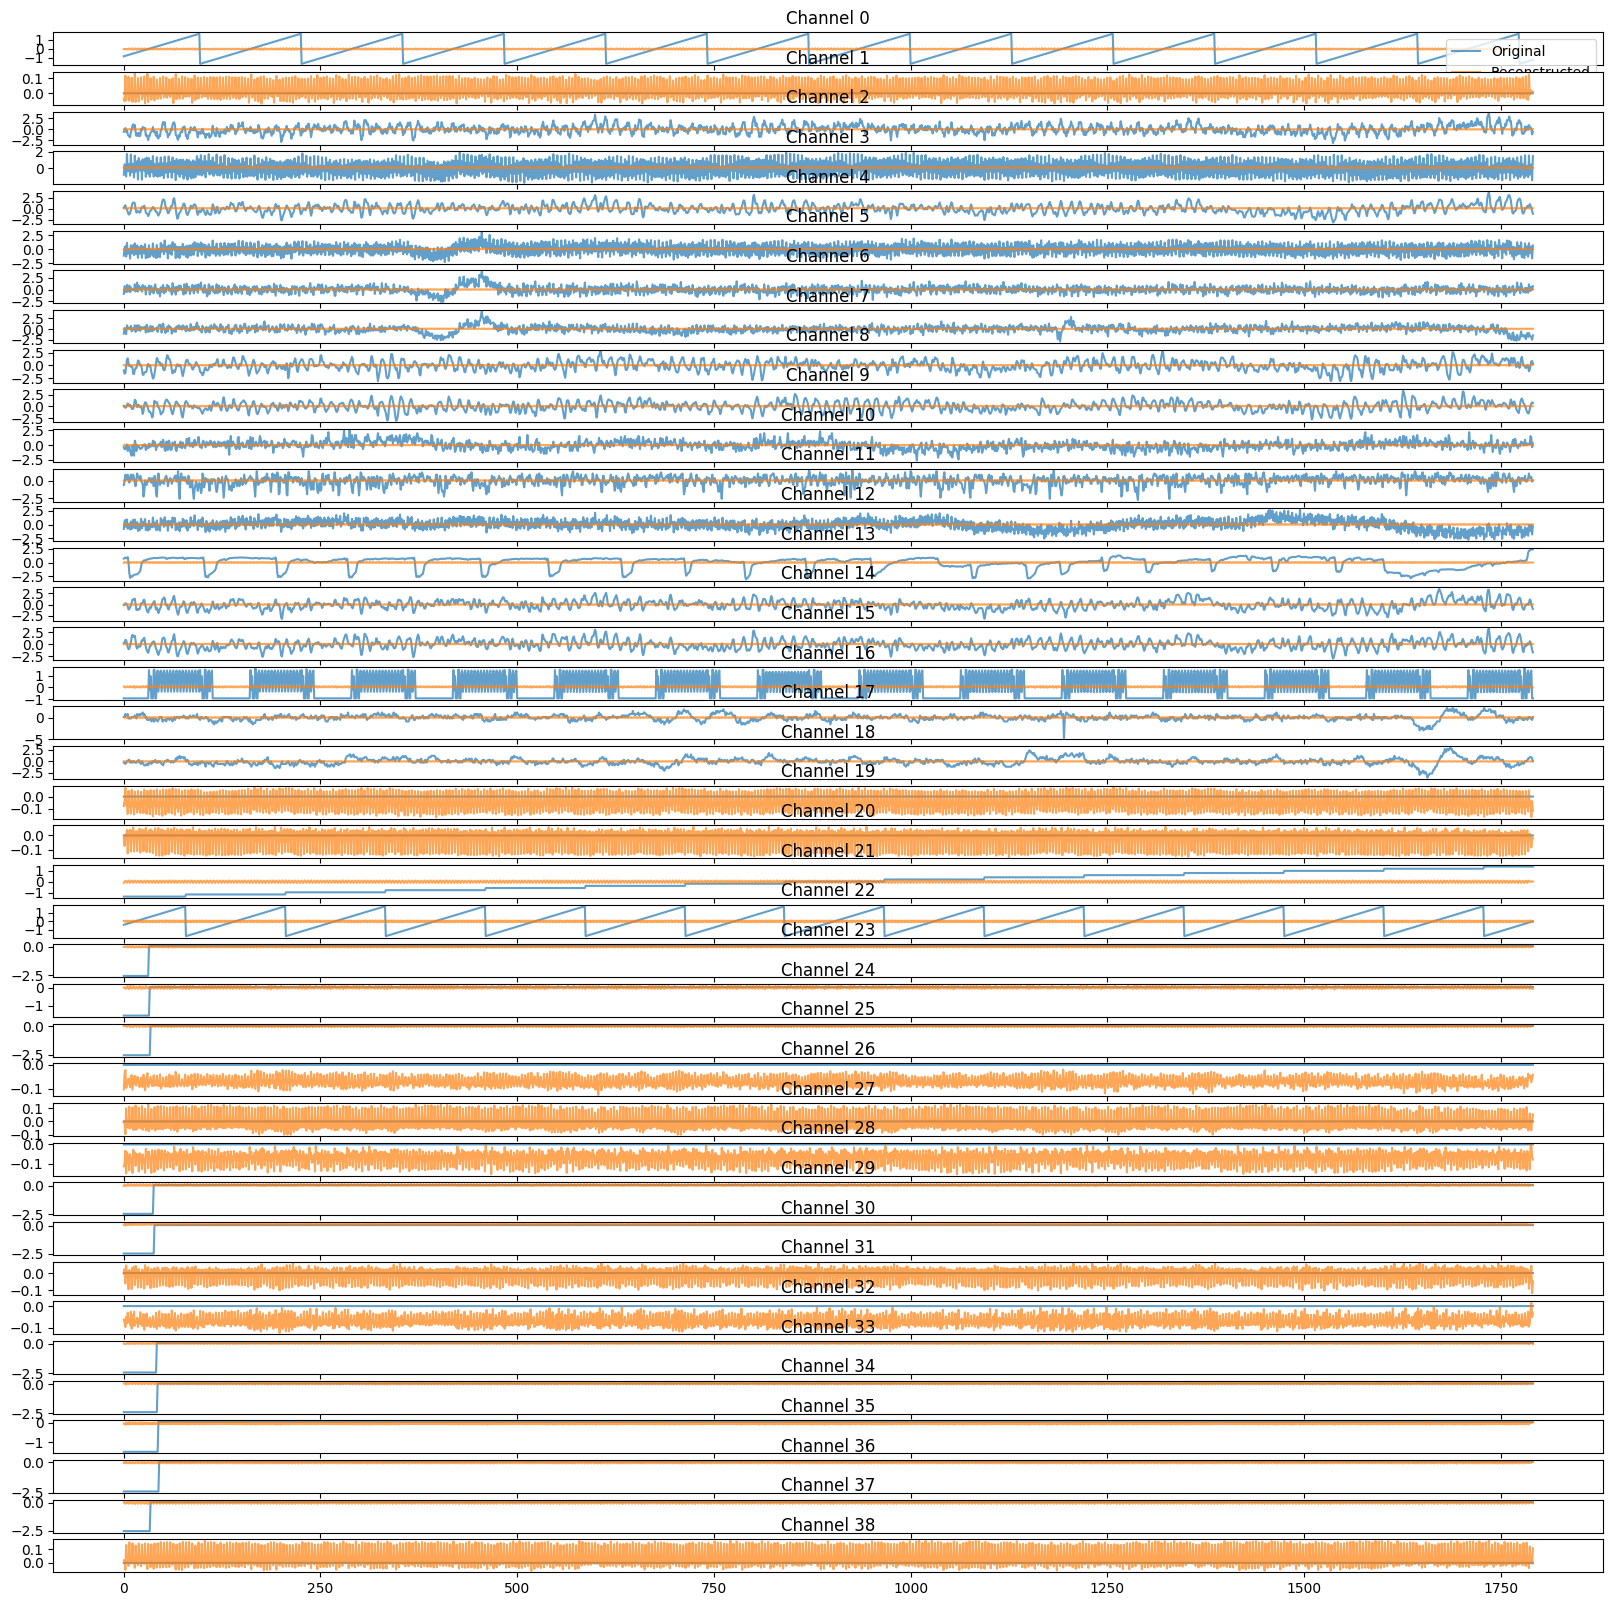

In [32]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_batch = next(iter(dataloader)).to(device)
    recon_batch = model(sample_batch)

# Compare first sample in the batch
orig = sample_batch[0].cpu().numpy()   # shape: (channels, time)
recon = recon_batch[0].cpu().numpy()   # shape: (channels, time)

plt.figure(figsize=(20, 20))
num_channels = orig.shape[0]
for i in range(num_channels):
    plt.subplot(num_channels, 1, i+1)
    plt.plot(orig[i], label="Original", alpha=0.7)
    plt.plot(recon[i], label="Reconstructed", alpha=0.7)
    plt.title(f"Channel {i}")
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
